In [1]:
import os
import glob
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
import pickle

In [2]:
# =========================================================
# 1. LOAD DATASET
# =========================================================
def load_palm_vein_dataset(
    data_root="Multispectral Palmprint Database/NIR",
    img_size=(256, 256),
    num_persons=20
):
    """
    Load grayscale palm images, normalize to [0,1], flatten to vectors.
    Returns:
        X : (num_samples, H*W) float32
        y : (num_samples,) int64
        label_names : list of folder names ("0001", "0002", ...)
    """
    X = []
    y = []
    label_names = []

    all_dirs = sorted(
        d for d in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, d))
    )
    person_dirs = all_dirs[:num_persons]

    print(f"Using these persons: {person_dirs}")

    for label_idx, person in enumerate(person_dirs):
        label_names.append(person)
        folder = os.path.join(data_root, person)

        img_paths = []
        for ext in ("*.bmp", "*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff"):
            img_paths.extend(glob.glob(os.path.join(folder, ext)))

        if not img_paths:
            print(f"Warning: no images found in {folder}")
            continue

        for path in img_paths:
            img = Image.open(path).convert("L")
            img = img.resize(img_size)
            arr = np.array(img, dtype=np.float32) / 255.0
            X.append(arr.flatten())
            y.append(label_idx)

    X = np.stack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    return X, y, label_names

In [3]:
# =========================================================
# 2. MAIN PIPELINE
# =========================================================
# 2.1 Load data
X, y, label_names = load_palm_vein_dataset(
    data_root="Multispectral Palmprint Database/NIR",
    img_size=(256, 256),
    num_persons=30
)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("#classes:", len(label_names))

# 2.2 Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train size:", X_train_raw.shape[0], "Test size:", X_test_raw.shape[0])

# 2.3 Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# 2.4 PCA
n_components = 150
pca = PCA(
    n_components=n_components,
    whiten=True,
    random_state=42
)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape:", X_test_pca.shape)

Using these persons: ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030']
X shape: (360, 65536)
y shape: (360,)
#classes: 30
Train size: 288 Test size: 72
X_train_pca shape: (288, 150)
X_test_pca shape: (72, 150)


In [ ]:
# =========================================================
# 3. TRAIN SVM (GridSearchCV on PCA features)
# =========================================================
svm = SVC(
    probability=True,     # needed for predict_proba (verification + calibration)
    random_state=42
)

param_grid = {
    "C": [0.1, 1, 10],
    "gamma": [0.0001, 0.001, 0.1],
    "kernel": ["rbf", "poly"]
}

print("Training SVM with GridSearchCV (this may take a while)...")

grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring="accuracy"
)

grid.fit(X_train_pca, y_train)

best_svm = grid.best_estimator_
print("\nBest hyperparameters found:")
print(grid.best_params_)
print(f"Best CV accuracy: {grid.best_score_:.4f}")

# =========================================================
# 4. SAVE MODEL
# =========================================================
model_path = "palm_svm_pca_best_model.sav"
with open(model_path, "wb") as f:
    pickle.dump(
        {
            "svm": best_svm,
            "scaler": scaler,
            "pca": pca,
            "label_names": label_names
        },
        f
    )

print(f"SVM+PCA model + scaler + pca saved to: {model_path}")


Training SVM with GridSearchCV (this may take a while)...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best hyperparameters found:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best CV accuracy: 0.8264
SVM+PCA model + scaler + pca saved to: palm_svm_pca_best_model.sav


In [ ]:
# =========================================================
# 5. EVALUATE
# =========================================================
y_train_pred = best_svm.predict(X_train_pca)
y_test_pred = best_svm.predict(X_test_pca)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n================ SVM + PCA METRICS ================")
print(f"Train Accuracy (SVM+PCA): {train_acc:.4f}")
print(f"Test  Accuracy (SVM+PCA): {test_acc:.4f}")
print("===================================================\n")

print("Classification report (test set, SVM+PCA):")
print(classification_report(y_test, y_test_pred, target_names=label_names))

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix (test set, SVM+PCA):")
print(cm)


================ SVM + PCA METRICS ================
Train Accuracy (SVM+PCA): 1.0000
Test  Accuracy (SVM+PCA): 1.0000

Classification report (test set, SVM+PCA):
              precision    recall  f1-score   support

        0001       1.00      1.00      1.00         2
        0002       1.00      1.00      1.00         2
        0003       1.00      1.00      1.00         2
        0004       1.00      1.00      1.00         3
        0005       1.00      1.00      1.00         2
        0006       1.00      1.00      1.00         2
        0007       1.00      1.00      1.00         3
        0008       1.00      1.00      1.00         3
        0009       1.00      1.00      1.00         2
        0010       1.00      1.00      1.00         2
        0011       1.00      1.00      1.00         3
        0012       1.00      1.00      1.00         2
        0013       1.00      1.00      1.00         2
        0014       1.00      1.00      1.00         2
        0015       1.00   

<Figure size 700x700 with 0 Axes>

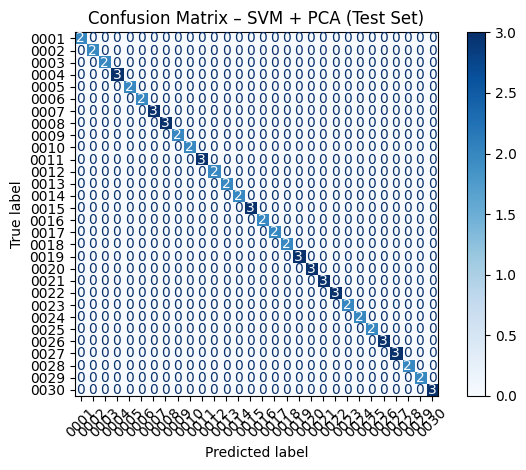

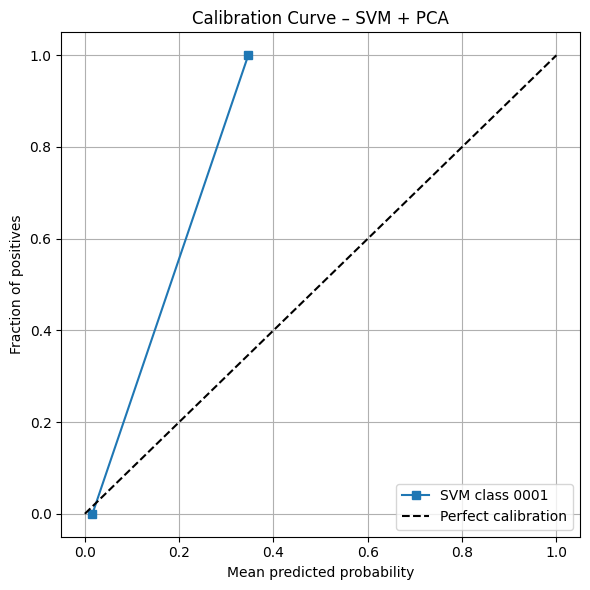

In [8]:
# =========================================================
# 6. PLOTS
# =========================================================

# 6.1 Confusion matrix plot
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix – SVM + PCA (Test Set)")
plt.tight_layout()
plt.show()

# 6.2 Calibration curve for one class (e.g. class 0)
# Get predicted probabilities for test set
probs_svm = best_svm.predict_proba(X_test_pca)  # (N_test, num_classes)

class_id = 0  # choose which person/class to inspect
y_true_binary = (y_test == class_id).astype(int)
y_prob_class = probs_svm[:, class_id]

prob_true_svm, prob_pred_svm = calibration_curve(
    y_true_binary, y_prob_class, n_bins=10, strategy="uniform"
)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred_svm, prob_true_svm, "s-", label=f"SVM class {label_names[class_id]}")
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve – SVM + PCA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# =========================================================
# 7. VERIFICATION FUNCTION (SVM + PCA)
# =========================================================
def verify_image_svm_pca(
    svm_model,
    scaler,
    pca,
    img_path,
    claimed_person_name,
    label_names,
    img_size=(256, 256),
    threshold=None
):
    """
    Verify if image at img_path belongs to claimed_person_name using SVM+PCA.
    Steps:
      - Load + grayscale + resize
      - Normalize to [0,1]
      - Flatten
      - Standardize + PCA
      - SVM.predict_proba -> probability for each class

    Returns:
        is_match (bool),
        predicted_name (str),
        proba (float)  # probability of the predicted class
    """
    # Load and preprocess image
    img = Image.open(img_path).convert("L").resize(img_size)
    arr = np.array(img, dtype=np.float32) / 255.0
    x_raw = arr.flatten().reshape(1, -1)

    # Same preprocessing as training
    x_scaled = scaler.transform(x_raw)
    x_pca = pca.transform(x_scaled)

    # Predict probabilities
    proba_vec = svm_model.predict_proba(x_pca)[0]
    pred_class = int(np.argmax(proba_vec))
    pred_name = label_names[pred_class]
    proba = float(proba_vec[pred_class])

    # Match decision with optional threshold
    if threshold is not None:
        is_match = (pred_name == claimed_person_name) and (proba >= threshold)
    else:
        is_match = (pred_name == claimed_person_name)

    return is_match, pred_name, proba


# ---- TEST VERIFICATION ----
test_img_path = "Multispectral Palmprint Database/NIR/0004/2_05.jpg"

is_match, pred_name, prob = verify_image_svm_pca(
    svm_model=best_svm,
    scaler=scaler,
    pca=pca,
    img_path=test_img_path,
    claimed_person_name="0004",
    label_names=label_names,
    img_size=(256, 256),
    threshold=None
)

print("Match:", is_match)
print("Predicted class:", pred_name)
print("Probability:", prob)


Match: True
Predicted class: 0004
Probability: 0.6005915567113301
